## Домашнее задание по теме: "Оценка точности модели, переобучение, регуляризация"

Описание задания:

Решить задачу классификации при помощи обучения модели логистической регрессии. Качество модели оценивается путем подсчета метрик TPR, FPR и построения графиков ROC-кривой, Precision-Recall. Данные для обучения модели хранятся в файле athletes.csv, который можно найти в материалах к занятию.

### 1. Преобразуйте данные:

---

a. проверьте наличие пропущенных значений. Преобразуйте/удалите пропуски по необходимости;

b. закодируйте категориальные переменные числовыми значениями по необходимости.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

In [ ]:
# для загрузки csv на google colab
from google.colab import files
uploaded = files.upload()

Saving athletes.csv to athletes.csv


In [ ]:
# создаем датафрейм из csv
df = pd.read_csv('./athletes.csv')
df.describe(include = "all")

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
count,1.153800e+04,11538,11538,11538,11537,11208.000000,10879.000000,11538,11538.000000,11538.000000,11538.000000
unique,NaN,11517,207,2,5595,NaN,NaN,28,NaN,NaN,NaN
top,NaN,Ahmed Mohamed,USA,male,2/18/93,NaN,NaN,athletics,NaN,NaN,NaN
freq,NaN,2,567,6333,9,NaN,NaN,2363,NaN,NaN,NaN
mean,4.999885e+08,NaN,NaN,NaN,NaN,1.766282,72.068205,NaN,0.057722,0.056769,0.061016
std,2.908648e+08,NaN,NaN,NaN,NaN,0.112719,16.177334,NaN,0.255910,0.239147,0.243320
min,1.834700e+04,NaN,NaN,NaN,NaN,1.210000,31.000000,NaN,0.000000,0.000000,0.000000
25%,2.450997e+08,NaN,NaN,NaN,NaN,1.690000,60.000000,NaN,0.000000,0.000000,0.000000
50%,5.002011e+08,NaN,NaN,NaN,NaN,1.760000,70.000000,NaN,0.000000,0.000000,0.000000
75%,7.539874e+08,NaN,NaN,NaN,NaN,1.840000,81.000000,NaN,0.000000,0.000000,0.000000


In [ ]:
# удаляем ненужное
df = df.drop(['id', 'name', 'nationality', 'dob'], axis=1)
# проверка на пропуски
df.isnull().sum()

sex         0
height    330
weight    659
sport       0
gold        0
silver      0
bronze      0
dtype: int64

In [ ]:
# заполнение отсутствующих значений роста и веса средними
df.fillna(df.mean(), inplace = True)
df.isnull().sum()

<ipython-input-6-cf038d38153a>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.mean(), inplace = True)


sex       0
height    0
weight    0
sport     0
gold      0
silver    0
bronze    0
dtype: int64

In [ ]:
# бинарное кодирование пола
le = LabelEncoder()
df['sex'] = le.fit_transform(df['sex'])

In [ ]:
# one hot encoding для преобразования категориального признака sport
df = pd.get_dummies(df, columns=['sport'])

### 2. Разделите выборку на обучающее (80% данных) и тестовое (20% данных) подмножества

---

In [ ]:
X =  df.drop(['sex'], axis=1)
y = df['sex']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

### 3. Постройте ROC-кривую с помощью функции sklearn.metrics. roc_curve.

---

In [ ]:
# обучаем модель
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000)

In [ ]:
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
# вычисление вероятностей для тестовой выборки
y_proba = clf.predict_proba(X_test)

In [ ]:
# вычисление ROC-кривой
fprs, tprs, thresholds = roc_curve(y_test, y_proba[:, 1])

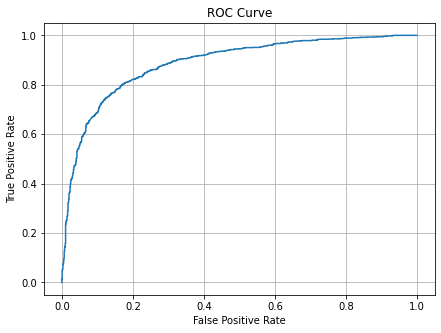

In [ ]:
# построение график ROC-кривой
plt.figure(figsize=(7, 5))
plt.plot(fprs,tprs)
plt.grid(axis = 'both')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

### 4. Вычислите значение ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score.

---

In [ ]:
# вычисление площади под ROC-Curve
from sklearn.metrics import auc
auc(fprs, tprs)

0.8863247869732563

### 5. Реализуйте подсчет метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn.

---

In [ ]:
# создаем массив с вероятностями и настоящим классом
df_pred = pd.DataFrame({
    'y_prob': y_proba[:, 1],
    'y_true': y_test
})

df_pred.sort_values(by='y_prob', inplace=True)

In [ ]:
def _roc_curve(probabilities, labels, thresholds, prre=False, debug=False):
    '''Функция для вычисления ROC Curve + Precision-Recall'''
    fprs = []
    tprs = []
    precisions = []
    recalls = []

    for threshold in thresholds:
        # перебор значения порогов
        y_pred = 0
        fp, tp, fn, tn = 0, 0, 0, 0

        for y_prob, y_true in zip(probabilities, labels):
            # подсчет fp, tp, fn, tn
            if y_prob >= threshold:
                y_pred = 1
            else:
                y_pred = 0

            if (y_pred == 1) & (y_true == 0):
                fp += 1
            elif (y_pred == 1) & (y_true == 1):
                tp += 1
            elif (y_pred == 0) & (y_true == 1):
                fn += 1
            else:
                tn += 1

        # вычисление fpr и tpr
        fpr = fp / (fp + tn)
        tpr = tp / (tp + fn)
        fprs.append(fpr)
        tprs.append(tpr)

        # вычисление precision и recall
        if prre: 
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            precisions.append(precision)
            recalls.append(recall)

        if debug:
          print(f'fps: {fp}, tps: {tp}, fns: {fn}, tns: {tn}')
          print(f'fpr: {fpr}, tpr: {tpr}')
          print(f'precision: {precision}, recall: {recall}')
          return None

    if prre:
        return fprs, tprs, precisions, recalls

    return fprs, tprs

In [ ]:
# проверка работы функции
_roc_curve(df_pred['y_prob'], df_pred['y_true'], [0.5], prre=True, debug=True)

fps: 187, tps: 1029, fns: 242, tns: 850
fpr: 0.18032786885245902, tpr: 0.8095987411487018
precision: 0.8462171052631579, recall: 0.8095987411487018


In [ ]:
# получение необходимых значений
_fprs, _tprs, _precisions, _recalls = _roc_curve(df_pred['y_prob'], df_pred['y_true'], df_pred['y_prob'].unique(), prre=True)

### 6. Постройте ROC-кривую с помощью вычисленных в п. 5 метрик: объедините графики из п. 3 и п. 6 в один. Сравните, сделайте вывод.

---

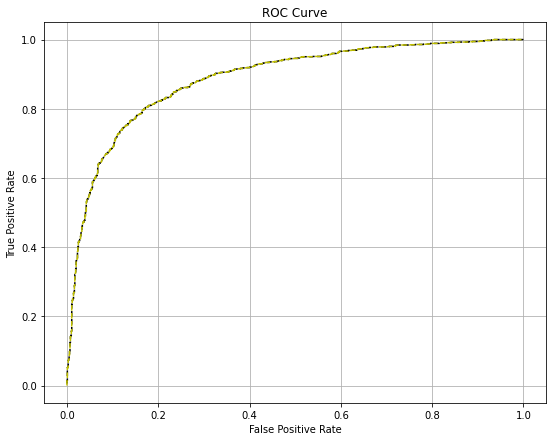

In [ ]:
# построение графика ROC-кривой (с объединением)
plt.figure(figsize=(9, 7))
plt.plot(_fprs, _tprs, '--', color='black')
plt.plot(fprs, tprs, '--', color='y')
plt.grid(axis = 'both')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

**Вывод:**

Графики полностью повторяют друг друга. Собственная реализация вычисления ROC-кривой дает те же результаты, что и релизация из sklearn.

### 7. Постройте график Precision-Recall, используя метрики, посчитанные в п. 5.

---

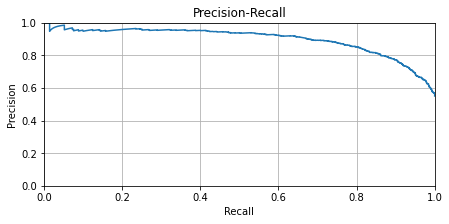

In [ ]:
# построение графика Precision-Recall
plt.figure(figsize=(7, 3))
plt.plot(_recalls, _precisions)
plt.grid(axis = 'both')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

### 8. *Вычислите значение ROC-AUC метрики, используя метрики, посчитанные в п. 5.

---

In [ ]:
# для вычисления auc score используем метод numpy - trapz (интегрируем)
-np.trapz(_tprs, _fprs)

0.8863247869732562

### 9. Сформулируйте выводы по проделанной работе:

a. как по полученным графикам сделать вывод о качестве модели? Как вы оцениваете обученную модель исходя из подсчитанных метрик?

b. *может ли ROC-кривая проходить ниже диагонали?

---

По полученным метрикам Precision/Recall мы можем оценить точность и полноту классификации. В нашем случае при пороге в 0.5 получаем значения: precision: 0.8462171052631579, recall: 0.8095987411487018. Это говорит о том, что в ~15 процентов случаях мы не правильно классифицировали НЕцелевой объект (false positive), и 20% целевых объектов также не было классифицированно. В зависимости от требований и целей мы можем менять данное соотношение.

С помощью ROG-кривой мы можем визуально наилучшим образом подобрать порог отсечения. Данный график показывает отношение true positive к false positive.

Исходя из данных метрик можно сделать вывод о том, что модель обучена неплохо, хотя конечно, есть куда стремиться.

ROC-кривая находящася на диагонали означает случайный принцип классификации объектов. Если кривая упадет ниже диагонали это означает, что модель работает "против нас". С моделью в данном случае точно что-то не так.
